# How to use the rtfits-module

In [1]:
import numpy as np
import pandas as pd
import random

from rt1.rt1 import RT1

from rt1.rtfits import Fits

from rt1.volume import Rayleigh
from rt1.volume import LinCombV

from rt1.surface import CosineLobe
from rt1.surface import Isotropic
from rt1.surface import HenyeyGreenstein as HGsurface
from rt1.surface import LinCombSRF

# Generation of a Dataset



In [23]:
# define Volume- and Surface properties used for the generation of the dataset
V = Rayleigh(omega = 0.1, tau = 0.1)
SRF = LinCombSRF([[0.5, HGsurface(t=0.0001, ncoefs=10)], 
                  [0.5, CosineLobe(i=8, ncoefs=10)]])

# set the incidence-angles for the dataset
inc_array = [
       np.deg2rad(np.arange(5, 75,2)),
       np.deg2rad(np.arange(10, 45)),
       np.deg2rad(np.arange(15, 61)),
       np.deg2rad(np.arange(32, 76)),
       np.deg2rad(np.arange(21, 55))
      ]

# set omega, tau and NormBRDF values for the fit
tau = [.2,.5,.3,.56,.32]
omega = [.1,.1,.54,.23,.62]
NormBRDF = [.4,.6,.8,.12,.24]

# initialize empty data-list
data = []

fn_input = None
_fnevals_input = None

for i, inc in enumerate(inc_array):
    V.tau = tau[i]
    V.omega = omega[i]
    SRF.NormBRDF = NormBRDF[i]
    
    R = RT1(1., inc, inc, np.ones_like(inc) * 0., np.ones_like(inc) * np.pi, 
            V=V, SRF=SRF, fn_input=fn_input, _fnevals_input = _fnevals_input, geometry='mono')
    # store pre-calculated coefficients
    fn_input = R.fn
    _fnevals_input = R._fnevals

    Itot = R.calc()[0]
    
    # add some random noise
    max_noise = np.max(Itot)/20.
    noise = np.random.uniform(low=0., high=max_noise, size=(len(inc),))
    
    Itot = Itot + noise
    
    # evaluate the total scattering contribution and add it to the dataset
    data = data + [Itot]

evaluating fn-coefficients...
generation of _fnevals functions...
symengine


# Fit of Model

In [24]:
# setup dataset in required shape
index = pd.date_range('1.1.2018', '1.5.2018')

sig = pd.DataFrame(data, index=index).stack().droplevel(level=1, axis=0)
inc = pd.DataFrame(inc_array, index=index).stack().droplevel(level=1, axis=0)
dataset = pd.DataFrame(dict(inc=inc, sig=sig))

In [25]:
# fit results
# verbose, ftol, xtol, gtol and x_scale are keywords that are forwarded
# to the scipy.optimize.least_squares() function.

# define Model to be fitted to the dataset
# note that this is not the same specification as in the generation of the dataset!

def set_V_SRF(omega, tau, N):
    V = Rayleigh(omega = omega, tau = tau)
    SRF = HGsurface(t=0.55, ncoefs=10, NormBRDF = N)

    # uncomment the following lines to use the functions that have been used to generate the dataset
    V = Rayleigh(omega = omega, tau = tau)
    SRF = LinCombSRF([[0.5, HGsurface(t=0.0001, ncoefs=10)], 
                      [0.5, CosineLobe(i=8, ncoefs=10)]], NormBRDF = N)
    return V, SRF


# initialize fit-class object
#   sig0 is set to False since the dataset is given as intensity-values
#   dB is set to False since the dataset is given in linear-units


defdict = dict(omega =  [True, .2, 'D', ([0.], [1.])],
               tau =    [True, .2, 'D', ([0.], [1.])],
               N =      [True, .2, 'D', ([0.], [1.])])

fit = Fits(dataset=dataset, verbose=0, 
           sig0=False, dB=False, 
           set_V_SRF = set_V_SRF,
           defdict=defdict, int_Q=True,
           lsq_kwargs=dict(verbose=2, ftol=1e-5, gtol=1e-5, xtol=1e-3))


In [33]:
fit.model_definition
fit.performfit()

-----------------------------------------------------------------------------
# SCATTERING FUNCTIONS 
 Volume: Rayleigh                    | Surface: LinCombSRF

# Interaction-contribution?      True

----------------------------- FITTED PARAMETERS -----------------------------
     NAME     |     START    |  VARIABILITY  |    BOUNDS    | INTERPOLATION |
 omega        | 0.2          | D             | 0.0-1.0      | False         |
 tau          | 0.2          | D             | 0.0-1.0      | False         |
 N            | 0.2          | D             | 0.0-1.0      | False         |

--------- FIXED PARAMETERS ----------|---------- AUXILIARY DATASETS ---------
-----------------------------------------------------------------------------
# LSQ PARAMETERS 
 verbose        = 2                    gtol           = 1e-05
 ftol           = 1e-05                xtol           = 0.001
-----------------------------------------------------------------------------
   Iteration     Total nfev     

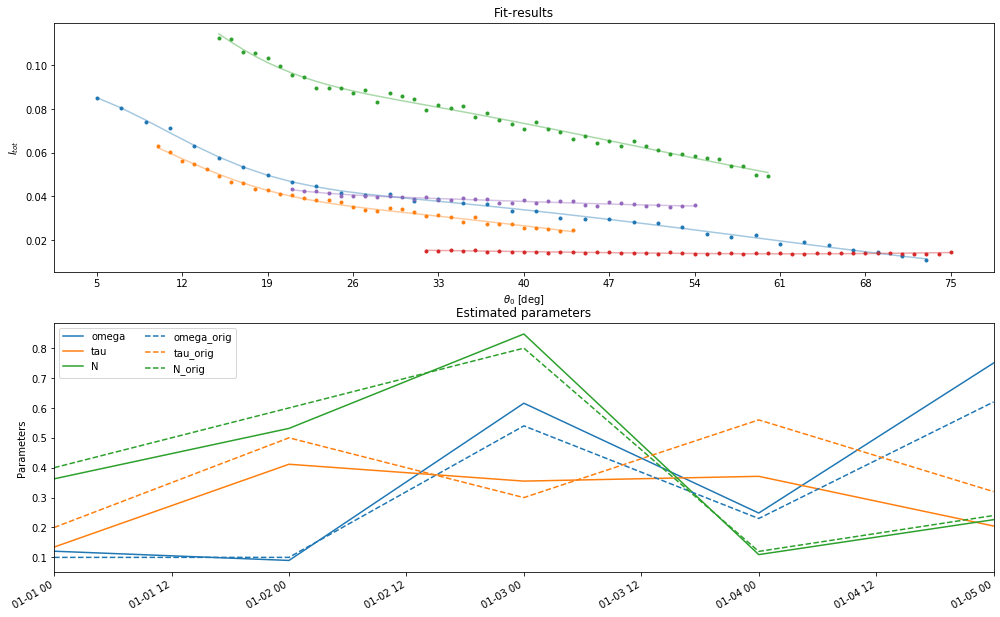

In [34]:
# print fit-results
truevals = pd.DataFrame({'omega_orig' : omega,
                         'tau_orig' : tau,
                         'N_orig' : NormBRDF},
                        index=index)
                        
fig = fit.plot.results()
# overplot true-values
_ = truevals.plot(ax=fig.axes[1], ls='--')
_ = fig.axes[1].legend(ncol=2)

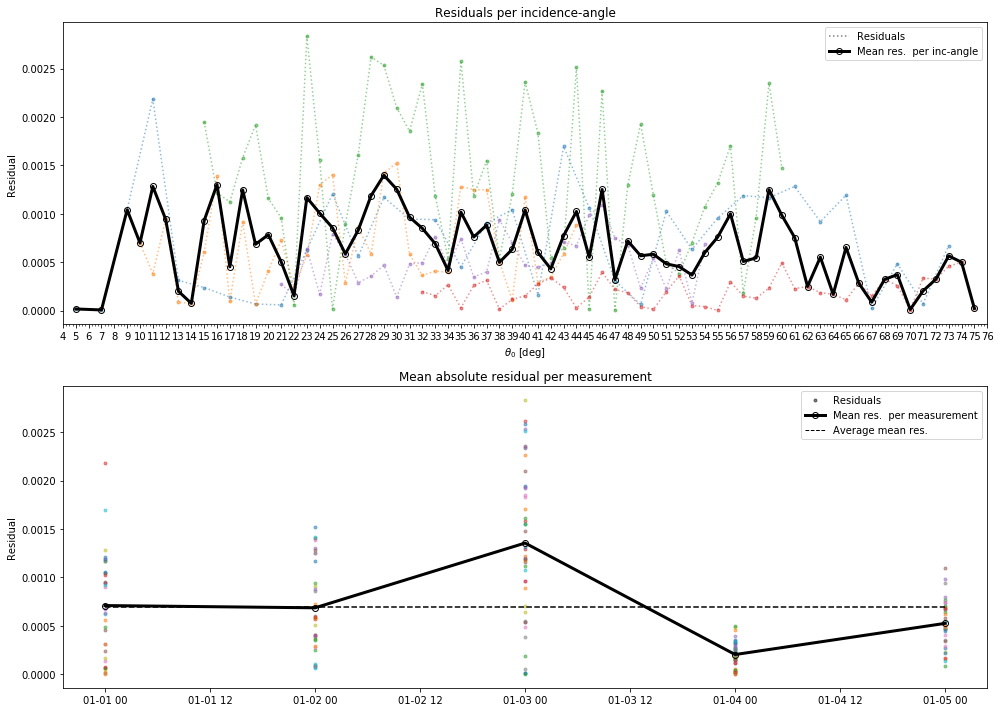

In [35]:
## print residuals
_ = fit.plot.fit_errors()